# General workflow
This workflow is a starting point to demonstrate the functionality of the containers and to detect and classify difficult cases

In [1]:
import numpy as np
import pandas as pd
import skimage
import Images
import ModelUNet_v2 #version 2 learns areas and boundaries of nuclei
import matplotlib.pyplot as plt

import copy

import plotly #plan to do interactive plots

/home/lienhard/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#some definitions
debug=False #perform on a subset --> faster
model_shape=(256,256,3) #works with shape (2^x, 2^x) only?
model_name='unet_{}x{}_xent_v2'.format(model_shape[0],model_shape[1])
if debug:
    model_name += '_debug'

print('the model will be called \''+model_name+'\'')


the model will be called 'unet_256x256_v2'


## Training
* load training data
* train the model (if not yet done)
* 

100%|██████████| 603/603 [01:40<00:00,  5.97it/s]


    size_x  size_y  n_channels  nuclei_n  nuclei_meanSz  nuclei_stdSz  \
80     256     320           3        10           1580          1157   

    nuclei_minSz  nuclei_maxSz  
80           127          3857  


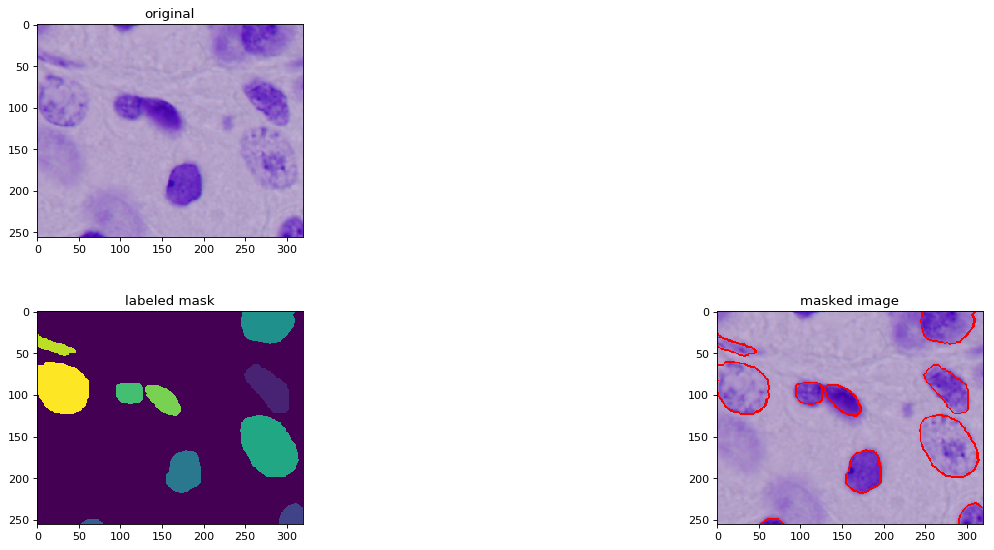

In [3]:
train=Images.Images("../input/stage1_train")
if debug:
    #subselect, to make it faster 
    train=train.subset(idx=range(20))
    #todo: overload [] to get this

#set aside 10% for validation
val=train.subset(np.arange(train.n()*.9, train.n()))
train=train.subset(np.arange(train.n()*.9,))

#load the image files (in original size)    
train.load_images()
train.load_masks()
train.features.head()    
plt.figure(figsize=(18, 12), dpi= 80, facecolor='w', edgecolor='k')

train.show_image()

In [4]:
# initialize and train the model 
# to detect unlabled masks (e.g. the forground vs background)

model=ModelUNet_v2.ModelUNet(name=model_name, shape=model_shape)
#question: should the model design be adapted according to image dimensions?
if not model.trained:
    model.fit_model(train)


found area model file unet_256x256_v2_area.h5
found boundary model file unet_256x256_v2_boundary.h5


In [5]:

#add_pred ruft models.predict auf, das folgendes macht:
# 1) area prediction (wie im beispiel von dem wir geklaut haben)
# 2) boundaries prediction (tolle neue innovation von uns)
# 3) beides nutzen um die labels zu asignen
# 4) rescalen zur originalgröße


#add labled predictions to container
train.add_predictions(model)
# this adds iou scores to train.features and train.nuc_features
# scores berechnen dautert ca 1 sec pro bild... ich berechne ne menge scores

print( train.features.drop(['ids'], axis=1).head() ) 
print("expected LB score(train): {}".format(np.mean(train.features['iou_score'])))
fig=plt.figure(figsize=(18, 12), dpi= 80, facecolor='w', edgecolor='k')

train.show_image()

predicting area...
predicting boundaries...


  0%|          | 0/603 [00:00<?, ?it/s]/home/lienhard/.local/lib/python3.6/site-packages/skimage/segmentation/_join.py:118: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.

  1%|          | 4/603 [00:00<00:15, 38.94it/s]

labeling predictions...


  0%|          | 0/603 [00:00<?, ?it/s]

computing scores... 


AttributeError: 'Images' object has no attribute 'preds'

In [ ]:
image_id=1
plt.figure(figsize=(18, 12), dpi= 80, facecolor='w', edgecolor='k')
train.show_image(image_id)
#print(train.nuc_features.head())

train.nuc_features.loc[train.nuc_features['img_id']==image_id,:]

In [ ]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(18, 12), dpi= 80, facecolor='w', edgecolor='k')
train.show_image()

In [ ]:
#same on validation data
val.load_images()
val.load_masks()
val.add_predictions(model)
val.features.drop(['ids'], axis=1).head()
print("expected LB score(val): {}".format(np.mean(val.features['iou_score'])))


In [ ]:
fig=plt.figure(figsize=(18, 12), dpi= 150, facecolor='w', edgecolor='k')
val.show_image()

## Prediction (on test data)
* load test data
* use model to predict masks
* prepare submission file

In [ ]:
test=Images.Images("../input/stage1_test")

#load the image files (in original size)    
test.load_images()
print('making predictions...')
test.add_predictions(model)
#much faster, no scores to calculate


In [ ]:
submission_file='submission_' + model_name + '.csv'
test.write_submission(submission_file)



In [ ]:

##########
# scores #
##########
print('Scores for first test image:')
#unlabeled IOU
print('IoU: {}'.format(Images.iou(val.masks[0] > 0, unlab_pred[0]>0.5)))
#labled IOUs per nucleus
print('IoU per nucleus: {}'.format(Images.iou(val.masks[0], val.pred[0])))
#mean IOU
print('mean IoU: {}'.format(np.mean(Images.iou(val.masks[0], val.pred[0]))))
# fraction of nuclei > th
print('fraction of nuclei has IoU > 0.5: {}'.format(Images.iou_score(val.masks[0], val.pred[0], th=[.5])))
print('fraction of nuclei has IoU > 0.95: {}'.format(Images.iou_score(val.masks[0], val.pred[0], th=[.95])))
# fraction of nuclei > th average over range of thresholds
print('IoU score (over range of thresholds): {}'.format(Images.iou_score(val.masks[0], val.pred[0])))

val.show_image(0)